# Predicting Significant Flight Delays using Supervised Learning

In this notebook I present my work in predicting flight delays by use of supervised learning.

## Business Understanding

Many consultants travel frequently over long distances for business purposes. Managers at a consulting firm might be interested in how to minimize risk when booking flights. One pertinent concern for these managers is how to reduce the risk of significant flight delay to ensure that consultants can utilize air travel reliably and efficiently.

My goal is to predict whether a given flight will be significantly delayed given several known factors about the flight such as time of year, airline, time of departure, and other significant factors. An effective model of this kind will assist managers in understanding potential risks so that they can make more informed decisions when booking flights.

## Data Understanding

I obtained data for use by the public domain from https://www.kaggle.com/datasets/robikscube/flight-delay-dataset-20182022 containing flight data spanning between 2018 and 2022. Each row pertains to a flight and includes several features such as time of year, airline, origin/destination airports, departure/arrival time blocks, and distance, among others. This data will provide an abundance of flights to build our model from as well as several promising features to use as predictors.

I will bulid my model on a random sample of 100,000 flights from a year's worth of raw data spanning from August 2021 to July 2022.

## Data Preparation

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
df_original = pd.read_csv('sample.csv')

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


We will be selecting features that would be known prior to a flight's departure and that could provide useful information for predicting delays. We will be excluding features that would not be known prior to takeoff, as well as identifiers with no interpretability.

In [3]:
to_keep = ['Quarter',
           'Month', 'DayOfWeek', 'Operating_Airline ',
           'Origin', 'Dest',
           'DepTimeBlk', 'ArrDel15', 'ArrTimeBlk', 'Cancelled', 'Distance']

df = df_original[to_keep]

Our target variable will be a binary indicator that yields 1 if a flight is delayed by at least 15 minutes or cancelled, and yields 0 otherwise.

In [4]:
df['Target'] = 0
for idx, row in df.iterrows():
    if row['ArrDel15'] == 1 or row['Cancelled'] == 1:
        df.at[idx, 'Target'] = 1
df.drop(['ArrDel15','Cancelled'], axis=1, inplace=True)

<ipython-input-4-67ae4c08d16f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = 0
C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Distance', ylabel='Density'>

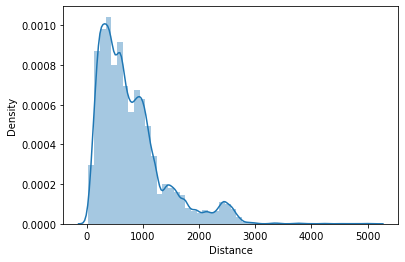

In [5]:
sns.distplot(df['Distance'])

We will perform a logarithmic transformation on distance to balance its skewed distribution:

In [14]:
"""
remaining to_keep:
['Quarter', 'Month', 'DayOfWeek', 'Operating_Airline ', 'Origin', 'Dest', 'DepTimeBlk', 'ArrTimeBlk']
"""
len(df['Origin'].value_counts())

372

C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
<ipython-input-6-99718ac2d7c6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Distance'] = np.log(df['Distance'])


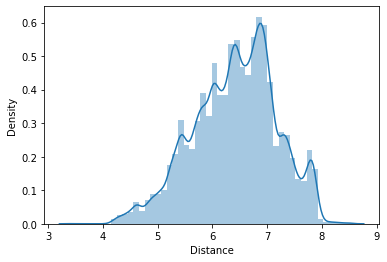

In [6]:
df['Distance'] = np.log(df['Distance'])
sns.distplot(df['Distance'])

In [13]:
df['Target'].value_counts(normalize=True)

0    0.77783
1    0.22217
Name: Target, dtype: float64

Observations:
* Nearly 80% of flights in our dataset are non-delayed/cancelled. Class imbalance could be a pertinent concern when building our models.

As most of our predictors are categorical, we will apply one-hot encoding to convert categorical features to numeric.

In [23]:
from sklearn.preprocessing import OneHotEncoder

X = df.drop(['Target'], axis=1)
y = df['Target']

X_cat = X.drop(['Distance'], axis=1)
X_num = X[['Distance']]

ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(X_cat)

X_cat_ohe = pd.DataFrame(
    data=ohe.transform(X_cat),
    index=X_cat.index
)

X_final = pd.concat([X_num, X_cat_ohe], axis=1)

## Modeling and Evaluation

We will use 75% of our data for training our model and 25% of our data for testing our model.

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final, y, random_state=100)

We will evaluate each model using an accuracy score for training and testing predictions. We will also use a confusion matrix and related statistics for the training predictions. In particular, we will calculate:

* Percentage of predicted delays/cancellations that were delayed/cancelled
* Percentage of predicted non-delays/cancellations that were not delayed/cancelled

These particular statistics would be relevant to a stakeholder, who would be interested in the likelihood of a given positive or negative prediction being correct.

In [25]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

def get_metrics(y_train, y_train_pred, y_test, y_test_pred, c):
    print('Train accuracy: ', accuracy_score(y_train, y_train_pred))
    print('Test accuracy: ', accuracy_score(y_test, y_test_pred))

    tn = c[0][0]
    fp = c[0][1]
    fn = c[1][0]
    tp = c[1][1]
    
    print()
    print("TN: {}\tFP:{}\nFN: {}\tTP: {}".format(tn, fp, fn, tp))
    print()
    
    print("% Predicted delays/cancellations that were delayed/cancelled: {}".format(tp/(tp+fp)))
    print("% Predicted non-delays/cancellations that were not delayed/cancelled: {}".format(tn/(tn+fn)))

Our initial, baseline model will be a simple decision tree model with default parameters.

In [26]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=100)
clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)
c = confusion_matrix(y_test, y_test_pred)

get_metrics(y_train, y_train_pred, y_test, y_test_pred, c)

Train accuracy:  0.9952
Test accuracy:  0.69188

TN: 15738	FP:3738
FN: 3965	TP: 1559

% Predicted delays/cancellations that were delayed/cancelled: 0.2943175382291863
% Predicted non-delays/cancellations that were not delayed/cancelled: 0.7987616099071208


A few observations: 
* Our model appears to be overfit, as training accuracy is significantly higher than testing accuracy.
* Of the positive (delayed/cancelled) predictions that we make, few are actually correct.
* Most of our negative (non-delayed/cancelled) predictions are correct.

We will make a few adjustments to the previous model:
1. We will conduct a grid search on various model parameters to optimize it. In particular, we will optimize our model with respect to its F1 score, which is designed to balance false positives and false negatives to yield a good "overall" fit.
2. We will utilize the *class_weight='balanced'* parameter. This is because we believe that class imbalance is contributing to our low metrics.


In [9]:
from sklearn.model_selection import GridSearchCV

# clf_grid = DecisionTreeClassifier()

# param_grid = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [2, 5, 10],
#     'class_weight':['balanced']
# }

# gs_tree = GridSearchCV(clf_grid, param_grid, cv=3, scoring='f1')
# gs_tree.fit(X_train, y_train)

# gs_tree.best_params_

In [27]:
clf_best = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=10, min_samples_leaf=2, class_weight='balanced', random_state=100)
clf_best.fit(X_train, y_train)

y_train_pred = clf_best.predict(X_train)
y_test_pred = clf_best.predict(X_test)
c = confusion_matrix(y_test, y_test_pred)

get_metrics(y_train, y_train_pred, y_test, y_test_pred, c)

Train accuracy:  0.5462266666666666
Test accuracy:  0.53132

TN: 9534	FP:9942
FN: 1775	TP: 3749

% Predicted delays/cancellations that were delayed/cancelled: 0.2738295230443357
% Predicted non-delays/cancellations that were not delayed/cancelled: 0.8430453621009815


Observations:
* Our training and testing accuracy went down, but are roughly equal - we have solved the issue of overfitting.
* Our predicted delays/cancellations are still very inaccurate.
* Our negative predictions are slightly more accurate.

To further improve upon the model, we will instead use a random forest classifier built from several decision trees.

In [29]:
from sklearn.ensemble import RandomForestClassifier

# rfc_grid = RandomForestClassifier()

# param_grid_rfc = {
#     'n_estimators':[10],
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [5, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [2, 5, 10],
#     'class_weight':['balanced']
# }

# gs_rfc_tree = GridSearchCV(rfc_grid, param_grid_rfc, cv=3, scoring='f1')
# gs_rfc_tree.fit(X_train, y_train)

# gs_rfc_tree.best_params_

In [30]:
rfc = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=20, min_samples_split=10, min_samples_leaf=10, class_weight='balanced', random_state=100)

rfc.fit(X_train, y_train)

y_train_pred = rfc.predict(X_train)
y_test_pred = rfc.predict(X_test)
c = confusion_matrix(y_test, y_test_pred)

get_metrics(y_train, y_train_pred, y_test, y_test_pred, c)

Train accuracy:  0.6293466666666667
Test accuracy:  0.61344

TN: 12023	FP:7453
FN: 2211	TP: 3313

% Predicted delays/cancellations that were delayed/cancelled: 0.30772803269552296
% Predicted non-delays/cancellations that were not delayed/cancelled: 0.8446676970633694


Observations:
* Our training and testing accuracy have both increased from the previous model and have stayed roughly equal to each other. 
* Slightly more of our positive predictions are correct, but the percentage is still very low.
* Our negative predictions are roughly as accurate as they were in the previous model.

This model is the best performing decision-tree based model among those we have built. However, we still face the issue that most of our positive predictions are wrong. We will build another type of model, a logistic regression model, and compare performance to see if we can obtain better performance.

In [32]:
from sklearn.linear_model import LogisticRegression

# logreg_grid = LogisticRegression()

# param_grid_logreg = {
#     'fit_intercept':[True, False],
#     'class_weight':['balanced'],
#     'solver':['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs'],
#     'max_iter':[1000]
# }

# gs_logreg = GridSearchCV(logreg_grid, param_grid_logreg, cv=3, scoring='f1')
# gs_logreg.fit(X_train, y_train)

# gs_logreg.best_params_

In [33]:
logreg = LogisticRegression(fit_intercept=False, 
                            class_weight='balanced',
                            solver='lbfgs',
                            max_iter=100)

logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)
c = confusion_matrix(y_test, y_test_pred)

get_metrics(y_train, y_train_pred, y_test, y_test_pred, c)

Train accuracy:  0.6120933333333334
Test accuracy:  0.60556

TN: 11717	FP:7759
FN: 2102	TP: 3422

% Predicted delays/cancellations that were delayed/cancelled: 0.3060549145872462
% Predicted non-delays/cancellations that were not delayed/cancelled: 0.8478905854258629


C:\Users\nnetznik\Anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Observations:
* (compare to previous model)

### Final Model Selection

In [26]:
# TODO: make a table comparing model performances

The Random Forest model (following grid search) is the best performing model in terms of overall accuracy. This is the model we will use to draw conclusions for stakeholders.

## Conclusions

Here we overview implications for stakeholders.
* We did not successfully tune our model to predict delays accurately. One cannot make a reliable conclusion based on a positive prediction.
* Our model predicts non-delays accurately. Given a negative predction, one can be fairly confident that a flight will not be delayed or cancelled.

Future work could involve further tuning models, or introducing new models such as a naive Bayes probabilistic model. One could also consider using different sets of predictors by selecting different existing features or engineering new features.